Just starting to think about how I can do this. 

# Collecting Stats From Previously Gathered Data

### Importing Libraries

In [160]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys


In [170]:
def returnFullSeasonStats(teamName, yearArr):
    """
    Goes into stats folder and reads in the both stats and Info csv files
    Concats them into a single data frame and returns them.

    Args:
        teamName (string): the team name matching the name within Stats File
        yearArr (array of ints): Allows to make sure we can pull specific year ranges
    Returns:
        TeamPDStats: Pandas Data-Frame of team game stats from all seasons collected
        teamPDInfo: Pandas Data-Frame of game info from all seasons collected
    """
    #data frame holding things like total yards for every season collected
    teamPDStats = pd.DataFrame()
    #data frame holding things like weather for every game in every season collected
    teamPDInfo = pd.DataFrame()
    #gets all csv files for a team
    dirList = os.listdir(f"Stats/{teamName}/")
    for file in dirList:
        if(int(file[-8:-4]) not in yearArr):
            continue
        #if stats then --> else, it is the game info. 
        if "Stats" in file:
            curr = pd.read_csv(f"Stats/{teamName}/{file}")
            teamPDStats = pd.concat([teamPDStats, curr[2:]],axis = 1)
        else:
            curr = pd.read_csv(f"Stats/{teamName}/{file}")
            teamPDInfo = pd.concat([teamPDInfo, curr[2:]],axis = 1)
    #returns the collected, concected pds. 
    return teamPDStats, teamPDInfo
 
# def returnSpecificRow(teamDataFrame, statName):
#     """
#     Pulls specifc rows from a given dataframe with given stat name

#     Args:
#         statName (string): the name of stat within the dataframe
#         teamDataFrame (Pandas Data Fram): Passed dataframe containing all of the stats/info
#     Returns:
#         statPD: Dataframe of row querried for
#     """
#     print(teamDataFrame["Unnamed: 1"])
    
#     statPD = pd.DataFrame(teamDataFrame.loc[teamDataFrame["Unnamed: 1"].str.lower() == statName.lower(), teamDataFrame.columns[2]: teamDataFrame.columns[-1]].values.flatten())
#     return statPD
    # Handle duplicate "Unnamed: 1" columns
def returnSpecificRow(teamDataFrame, statName):
    stat_col = teamDataFrame["Unnamed: 1"]
    if isinstance(stat_col, pd.DataFrame):
        stat_col = stat_col.iloc[:, 0]   # take the first duplicate column

    # Filter row by statName (case-insensitive)
    row = teamDataFrame.loc[stat_col.str.lower() == statName.lower()]
    print(row)
    # Return only the Game columns (from Game0 to last)
    return row.iloc[0, 2:]  # Series instead of DataFrame

def extractNumberFromString(givenString):
    """
    Extracts a float from a string with a format. Requires this number to have a decimal point

    Args:
        givenString (string): string with number inside
    Returns:
        extractedFloat (float): the extracted number within the string
    """
    extractedFloat = givenString.extract(r"(\d+\.\d*)").astype(float)
    return extractedFloat

def getSpreadandScores(currFullSeasonStats, currFullSeasonInfo, currTeam):
    """
    parses out a dataframes data includin the spread all the scores,
        the difference in game scores ect. 
    Args:
        currFullSeasonStats (pandas Dataframe): dataframe with all the stats from 
            potentially mutliple seasons.
        
        currFullSeasonInfo (pandas Dataframe): dataframe with all the game info from 
            potentially mutliple seasons. IE spread, weather, ect.

        currTeam (str): the name of team currently interested in
    Returns:
        teamBeatSpread (Dataframe): how many points team beat spread by. Postive means won
        scoreDifference (Dataframe): differnce between team score and opponent score across seasons
        vegasSpread (Dataframe): Vegas predicted point spread
        teamScoreFloat (Dataframe): team of interest scores throughout seasons
        oppScoreFloat (Dataframe): opponents scores throughout seasons

    """
    #3 letter abbrivation 
    teamAbbr = currFullSeasonStats["Unnamed: 0"].iloc[0]
    teamAbbr = teamAbbr[0]
    #geting team scores and opp scores
    teamsScore = returnSpecificRow(currFullSeasonStats, f"{teamAbbr} Score")
    opponentScore = returnSpecificRow(currFullSeasonStats, "Opp Score")
    print(opponentScore)
    #[2:] and on to exclude the label and empty column
    #getting total score
    teamScoreFloat = teamsScore[0][2:].astype(float) 
    oppScoreFloat = opponentScore[0][2:].astype(float)
    #getting actual spread
    scoreDifference = pd.DataFrame(teamScoreFloat - oppScoreFloat)
    
    #getting vegas over under
    overUnder = returnSpecificRow(currFullSeasonInfo, "Over/Under")

    #getting vegas spread
    spread = returnSpecificRow(currFullSeasonInfo, "Vegas Line")

    
    #This takes the pandas array, with info like "45.5 (over)" and takes just the number
    #extract takes a regular exprexsion (regex) "\d" grabs number before decimal place
    #"/.?" grabs the the decimal point and "\d*" grabs the post decimal place. 
    #() tells .extract to only take what is in the parentheses until white space.
    overUnderNumber = extractNumberFromString(overUnder[0].str)
    spreadNumber =  extractNumberFromString(spread[0].str)

    #takes out nan and label rows
    overUnderNumber = overUnderNumber[2:]
    vegasSpread = spreadNumber[2:]
    #convering spread to be in format as vegas. 
    for i in range(1,len(scoreDifference)):
        if ("nan" not in str(spread[0][i])) and currTeam not in spread[0][i]:
            #if broncos were favored then switch there real spread to reflect they won
            #locate the row i in first column make it negative. 
            vegasSpread.iloc[i, 0] = -1 * vegasSpread.iloc[i, 0]

    teamBeatSpread = scoreDifference[:] - vegasSpread[:]
    
    return teamBeatSpread, scoreDifference, vegasSpread, teamScoreFloat, oppScoreFloat


In [171]:
#directory where Stats was stored
directory = 'Stats/'

yearArr = [2017,2018]

#array of each directory within stats
TeamNamesArr= os.listdir(directory)

for team in TeamNamesArr:
    if team == ".DS_Store":
        continue
    currFullSeasonStats, currFullSeasonInfo = returnFullSeasonStats(team, yearArr)
    teamBeatSpread, scoreDifference, vegasSpread, teamScoreFloat, oppScoreFloat = getSpreadandScores(currFullSeasonStats, currFullSeasonInfo, team)
    break



Empty DataFrame
Columns: [Unnamed: 0, Unnamed: 1, Game0, Game1, Game2, Game3, Game4, Game5, Game6, Game7, Game8, Game9, Game10, Game11, Game12, Game13, Game14, Game15, Unnamed: 0, Unnamed: 1, Game0, Game1, Game2, Game3, Game4, Game5, Game6, Game7, Game8, Game9, Game10, Game11, Game12, Game13, Game14, Game15]
Index: []

[0 rows x 36 columns]


/var/folders/xn/xm07qqqx6q93rm93tp51mjvh0000gn/T/ipykernel_60889/613912523.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  teamAbbr = teamAbbr[0]


IndexError: single positional indexer is out-of-bounds

## When the actual spread wins, it means the current team of interest beat the spread

ValueError: x and y must have same first dimension, but have shapes (30,) and (0,)

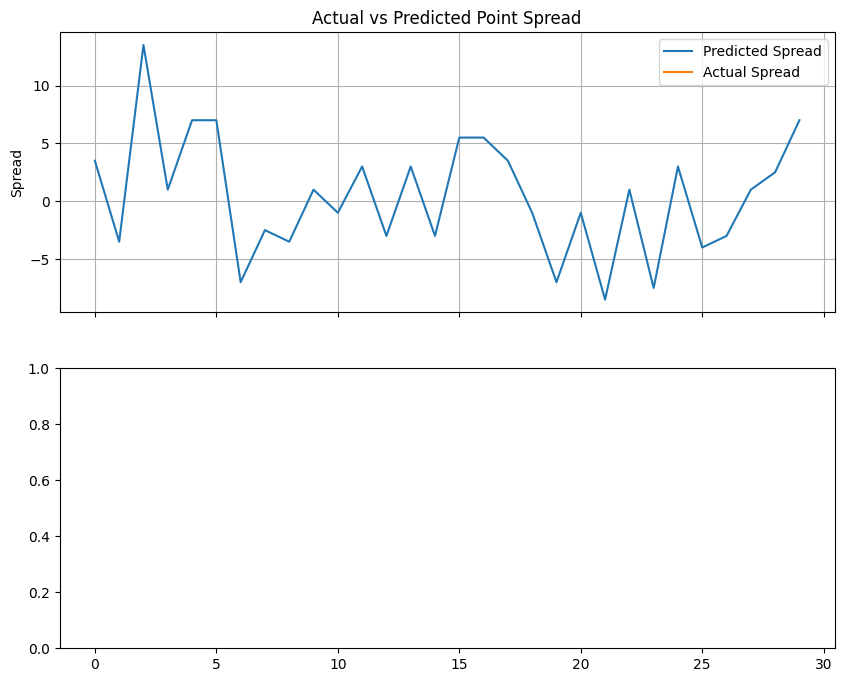

In [172]:
gamerange = np.arange(len(vegasSpread))
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Top subplot: spreads
axs[0].plot(gamerange, vegasSpread, label="Predicted Spread")
axs[0].plot(gamerange, scoreDifference, label="Actual Spread")
axs[0].set_ylabel("Spread")
axs[0].set_title("Actual vs Predicted Point Spread")
axs[0].grid(True)
axs[0].legend()

# Bottom subplot: scores
axs[1].plot(gamerange, teamScoreFloat, label="Team Score")
axs[1].plot(gamerange, oppScoreFloat, label="Opponent Score")
axs[1].set_xlabel("Game")
axs[1].set_ylabel("Score")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()


In [167]:
teamBeatSpread = scoreDifference[:] - vegasSpread[:]


In [115]:
currFullSeasonStats

,Unnamed: 0,Unnamed: 1,Game0,Game1,Game2,Game3,Game4,Game5,Game6,Game7,...,Game6,Game7,Game8,Game9,Game10,Game11,Game12,Game13,Game14,Game15
0,DEN,Cmp-Att-Yd-TD-INT,17-28-219-2-1,22-32-231-4-1,24-40-259-0-2,16-26-179-1-0,31-54-394-1-2,25-35-207-0-1,19-36-198-1-3,19-38-208-1-2,...,15-22-189-2-1,23-34-262-2-1,26-42-290-1-0,20-33-217-0-0,15-28-197-2-0,12-21-151-1-0,24-42-186-1-0,31-48-257-0-2,23-37-202-2-2,31-48-292-1-1
1,DEN,DEN Score,24,42,16,16,10,0,19,23,...,45,23,17,23,24,24,14,16,14,9
2,DEN,First Downs,22,26,21,16,20,12,23,14,...,15,22,19,16,17,16,22,22,19,19
3,DEN,Fourth Down Conv.,0-0,0-0,0-2,0-0,0-2,0-2,0-1,1-1,...,0-0,1-1,2-2,1-2,0-0,0-0,5-7,1-2,1-2,1-2
4,DEN,Fumbles-Lost,1-1,2-1,1-0,2-0,3-1,3-2,2-2,1-0,...,0-0,3-1,1-1,0-0,0-0,1-1,4-0,0-0,1-0,4-3
5,DEN,HomeTeam,True,True,False,True,True,False,False,False,...,False,False,True,False,True,False,False,True,False,True
6,DEN,Net Pass Yards,181,202,255,155,366,182,187,191,...,178,222,273,217,184,143,171,238,200,288
7,DEN,Opp Score,21,17,26,10,23,21,29,51,...,10,30,19,22,17,10,20,17,27,23
8,DEN,Opp_Cmp-Att-Yd-TD-INT,22-33-192-3-1,30-50-238-2-2,20-26-213-2-0,21-35-249-1-1,11-19-128-1-0,15-26-183-2-0,14-32-202-1-1,16-28-234-4-0,...,21-39-194-1-3,24-34-303-4-1,17-24-213-2-0,28-43-401-2-2,42-58-464-2-2,25-37-236-1-1,20-33-332-2-1,18-31-188-2-1,19-26-167-0-0,14-24-176-1-2
9,DEN,Opp_First Downs,17,16,16,11,12,14,16,25,...,14,20,17,26,25,20,24,21,16,17
